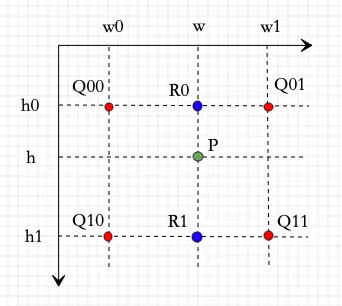

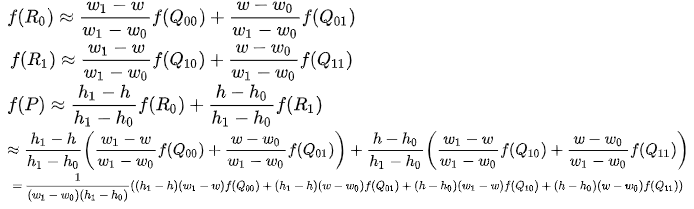

双线性插值代码实现

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def Bilinear_interpolation(src,new_size):#输入原图尺寸，新尺寸
    dst_w, dst_h = new_size #目标图像的尺寸 宽和高
    src_h, src_w = src.shape[:2] #原始图像的宽和高
    if src_h == dst_h and src_w == dst_w:
        return src.copy()
    
    #得到缩放的比例，定位目标点在原图的位置
    scale_x = float(src_w) / dst_w
    scale_y = float(src_h) / dst_h
    
    dst = np.zeros((dst_h,dst_w,3),dtype=np.unit8) #生成一张目标尺寸的空白图，遍历储值
                   
    for n in range(3):#循环channel
        for dst_y in range(dst_h): #循环高 height
            for dst_x in range(dst_w): #循环宽度 width
                
                #得到目标像素在原图上的坐标
                #每个像素点都是一个边长为1的正方形，对于坐标为（h,w)的像素点，他的中心是（h+0.5，w+0.5)
                src_x = (dst_x + 0.5) * scale_x - 0.5 
                src_y = (dst_y + 0.5) * scale_y - 0.5
                
                #左上角的点
                src_x_0 = int(np.floor(src_x)) #floor 向下取整
                src_y_0 = int(np.floor(src_y))
                
                #像素值的坐标为整数，边界为1，防止出界
                src_x_1 = min(src_x_0 + 1,src_w - 1)
                src_y_1 = min(src_y_0 + 1,src_h - 1)
                
                value_0 = (src_x_1 - src_x) * src[src_y_0,src_x_0,n] + (src_x - src_x_0) * src[src_y_0,src_x_1,n]
                value_1 = (src_x_1 - src_x) * src[src_y_1,src_x_0,n] + (src_x - src_x_0) * src[src_y_1,src_x_1,n]
                dst[dst_y,dst_x,n] = int((src_y_1 - src_y)*value_0) + int((src_y - src_y_0)*value_1)
    return dst

In [ ]:
if __name__ == '__main__':
    img_in = cv2.imread('timg.jpeg')
    img_out = Bilinear_interpolation(img_in,(1000,1000))
    cv2.imshow('src_img',img_in)
    cv2.imshow('dst_img',img_out)
    
    key = cv2.waitKey() #不断刷新图
    if key == 1000:
        cv2.destroyAllWindows()
    print(img_in.shape)
    print(img_out.shape)

Unet 代码实现

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
#先建立一个原始版本的下采样的block
class UNetConvBlock(nn.Module):
    def __init__(self,in_chans,out_chans,padding,batch_norm):
        super(UNetConvBlock,self).__init__()
        block = []#新建空的列表，要往里面填东西
        
        block.append(nn.Conv2d(in_chans,out_chans,kernel_size=3,padding=int(padding)))
        block.append(nn.ReLU())
        
        #检测有没有BN
        if batch_norm:
            block.append(nn.BatchNorm2d(out_chans))
        
        block.append(nn.Conv2d(out_chans,out_chans,kernel_size=3,padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_chans))
        
        self.block = nn.Sequential(*block) 
    def forward(self,x):
        out = self.block(x)
        return out

#写一个上采样的block
class UNetUpBlock(nn.Module):
    def __init__(self,in_chans,out_chans,up_mode,padding,batch_norm):
        super(UNetUpBlock,self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_chans,out_chans,kernel_size=2,stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode = 'bilinear',scale_factor=2),
                nn.Conv2d(in_chans,out_chans,kernel_size=1),)
        self.conv_block = UNetConvBlock(in_chans,out_chans,padding,batch_norm)
    
    #定义对feature map的裁剪函数
    def center_crop(self,layer,target_size):
        _,_,layer_height,layer_width = layer.size()
        diff_y = (layer_height - target_size[0])//2
        diff_x = (layer_width - target_size[1])//2
        return layer[:,:,diff_y:(diff_y + target_size[0]),diff_x:(diff_x + target_size[1])]
    
    def forward(self,x,bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge,up.shape[2:])
        out = torch.cat([up,crop1],1)
        out = self.conv_block(out)
        return out

In [30]:
class UNet(nn.Module):
    def __init__(
        self,
        in_channels = 1,
        n_classes = 2, #最终有多少个分类
        depth = 5, #网络的深度
        wf = 6,#第一层的个数，2的wf次方，正课中给出的数是64
        padding =False,
        batch_norm = False,
        up_mode = 'upconv',
    ):
        super(UNet,self).__init__()
        assert up_mode in ('upconv','upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(UNetConvBlock(prev_channels,2**(wf+i),padding,batch_norm))
            prev_channels = 2**(wf+i)
            
        self.up_path=nn.ModuleList()
        for i in reversed(range(depth-1)):
            self.up_path.append(UNetUpBlock(prev_channels,2**(wf+i),up_mode,padding,batch_norm))
            prev_channels = 2**(wf+i)
        self.last=nn.Conv2d(prev_channels,n_classes,kernel_size=1)
    
    def forward(self,x):
        blocks = []
        for i,down in enumerate(self.down_path):
            x = down(x)
            if i!=len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x,2)
        for i,up in enumerate(self.up_path):
            x = up(x,blocks[-i -1])
        return self.last(x)

In [31]:
x = torch.randn((1,1,572,572))#batch_size 是1 ，通道是1，输入572 572
unet = UNet()
unet.eval()
y_unet = unet(x)

In [32]:
y_unet.size()

torch.Size([1, 2, 388, 388])